In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical
from torch.autograd import Variable

# создаем энвайронмент с игрой
env = gym.make('Breakout-v0').unwrapped

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

# выбираем девайс для игры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))
DEVICE_ID = 1
divice = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

/home/r.astapov/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Is python : True
Device : cuda
Number of actions : 4


In [9]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 70000

# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
# В качестве последнего мы будем использовать состеканные 4 последовательных кадра игры.
# Это необходимо, чтобы агент понимал скорости и ускорения игровых объектов.

class StateHolder:
    def __init__(self):
        self.stack=0
        self.tmp = []
        self.len=0


    def push(self, img):
        if(self.len==0):
            self.tmp = [img]*4
            self.stack=torch.stack(self.tmp,1)
            self.len=1
        else:
            self.tmp.append(img)
            self.stack=torch.stack(self.tmp[-4:],1)
                        
    def get(self):
        return self.stack.to(device=device).byte()

    def reset(self):
        self.stack=0
        self.len=0
        self.tmp=[]
        

    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [29]:
# Задание 2. Собрать архитектуру сети (DQN).
# В качестве примера можно использовать сеть вида:
# Conv(4->32) -> Conv(32->64) -> Conv(64->64) -> FC(512) -> FC(ACTIONS_NUM)
# В качестве функций активации необходимо использовать ReLU(но совершенно не обязательно ими ограничиваться)
# Attention : не забудьте правильно инициализировать веса, это важно для данной задачи!

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7*7*64, 512)
        self.fc2 = nn.Linear(512, 4)
        self.relu = nn.ReLU()
        self.initialize()
        
    def initialize(self):
        for m in self.modules():
            if (type(m) == nn.Linear) or (type(m) == nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
            
        
        
    def forward(self, x):
        x = x.float()
        #x = self.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv1(x))
        #x = self.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv2(x))
        #x = self.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.conv3(x))
        x = self.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

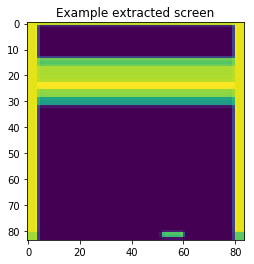

In [30]:
# Тут блок с кодом, генерирующим 1 кадр игры
# Обратите внимание, что выходным тензора является torch.ByteTensor со значениями 0-255
# Это сделанно намеренно для экономии места(4х экономия по сравнению с FloatTensor)
# Подумайте, где и как необходимо совершать преобразование ByteTensort -> FloatTensor, чтобы его можно было подавать в сеть. 

resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach()

env.reset()

plt.imshow(get_screen().cpu().reshape(-1,84).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [31]:
# Далее стандартный метод для выбора нового действия из лекции

policy_net = DQN().to(device)
target_net = DQN().to(device)
#policy_net = torch.load('policy_net.pt')
#target_net = torch.load('target_net.pt')

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4, amsgrad=True)

memory = ReplayMemory(50000)
#memory = torch.load('memory.pt')

state_holder = StateHolder()


# параметры для e-greedy стратегии выбора действия
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000

steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [32]:
# Еще немного методов из лекции

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

In [25]:
torch.save(policy_net,'policy_net.pt')

In [26]:
torch.save(target_net,'target_net.pt')

In [27]:
torch.save(memory,'memory.pt')

In [10]:
steps_done=2248390

episode: 0   score: 1.0   mean: 1.0
episode: 1   score: 1.0   mean: 1.0
episode: 2   score: 1.0   mean: 1.0
episode: 3   score: 1.0   mean: 1.0
episode: 4   score: 3.0   mean: 1.4
episode: 5   score: 1.0   mean: 1.3333333333333333
episode: 6   score: 1.0   mean: 1.2857142857142858
episode: 7   score: 0.0   mean: 1.125
episode: 8   score: 0.0   mean: 1.0
episode: 9   score: 1.0   mean: 1.0
episode: 10   score: 0.0   mean: 0.9090909090909091
episode: 11   score: 2.0   mean: 1.0
episode: 12   score: 2.0   mean: 1.0769230769230769
episode: 13   score: 0.0   mean: 1.0
episode: 14   score: 0.0   mean: 0.9333333333333333
episode: 15   score: 1.0   mean: 0.9375
episode: 16   score: 3.0   mean: 1.0588235294117647
episode: 17   score: 3.0   mean: 1.1666666666666667
episode: 18   score: 0.0   mean: 1.105263157894737
episode: 19   score: 8.0   mean: 1.45
episode: 20   score: 0.0   mean: 1.380952380952381
episode: 21   score: 0.0   mean: 1.3181818181818181
episode: 22   score: 1.0   mean: 1.3043478

episode: 184   score: 2.0   mean: 1.38
episode: 185   score: 0.0   mean: 1.36
episode: 186   score: 1.0   mean: 1.36
episode: 187   score: 0.0   mean: 1.36
episode: 188   score: 2.0   mean: 1.36
episode: 189   score: 2.0   mean: 1.35
episode: 190   score: 4.0   mean: 1.39
episode: 191   score: 2.0   mean: 1.39
episode: 192   score: 1.0   mean: 1.39
episode: 193   score: 0.0   mean: 1.38
episode: 194   score: 2.0   mean: 1.39
episode: 195   score: 2.0   mean: 1.41
episode: 196   score: 2.0   mean: 1.42
episode: 197   score: 2.0   mean: 1.42
episode: 198   score: 2.0   mean: 1.42
episode: 199   score: 2.0   mean: 1.43
Target net updated!
start train
episode: 200   score: 2.0   mean: 1.44
episode: 201   score: 3.0   mean: 1.46
episode: 202   score: 2.0   mean: 1.47
episode: 203   score: 2.0   mean: 1.49
episode: 204   score: 2.0   mean: 1.48
episode: 205   score: 1.0   mean: 1.46
episode: 206   score: 2.0   mean: 1.48
episode: 207   score: 0.0   mean: 1.47
episode: 208   score: 0.0   mean

episode: 392   score: 2.0   mean: 1.31
episode: 393   score: 1.0   mean: 1.3
episode: 394   score: 1.0   mean: 1.28
episode: 395   score: 2.0   mean: 1.3
episode: 396   score: 2.0   mean: 1.32
episode: 397   score: 0.0   mean: 1.28
episode: 398   score: 2.0   mean: 1.28
episode: 399   score: 3.0   mean: 1.31
episode: 400   score: 1.0   mean: 1.29
episode: 401   score: 1.0   mean: 1.3
Target net updated!
episode: 402   score: 2.0   mean: 1.3
episode: 403   score: 1.0   mean: 1.31
episode: 404   score: 0.0   mean: 1.27
episode: 405   score: 0.0   mean: 1.24
episode: 406   score: 1.0   mean: 1.24
episode: 407   score: 0.0   mean: 1.24
episode: 408   score: 1.0   mean: 1.25
episode: 409   score: 0.0   mean: 1.24
episode: 410   score: 3.0   mean: 1.25
episode: 411   score: 0.0   mean: 1.25
episode: 412   score: 1.0   mean: 1.24
episode: 413   score: 0.0   mean: 1.24
episode: 414   score: 0.0   mean: 1.21
episode: 415   score: 4.0   mean: 1.22
episode: 416   score: 2.0   mean: 1.24
episode: 

episode: 600   score: 4.0   mean: 1.14
episode: 601   score: 1.0   mean: 1.14
episode: 602   score: 1.0   mean: 1.14
episode: 603   score: 1.0   mean: 1.12
episode: 604   score: 0.0   mean: 1.12
episode: 605   score: 3.0   mean: 1.15
episode: 606   score: 0.0   mean: 1.13
episode: 607   score: 1.0   mean: 1.13
episode: 608   score: 0.0   mean: 1.09
episode: 609   score: 1.0   mean: 1.09
episode: 610   score: 0.0   mean: 1.06
episode: 611   score: 1.0   mean: 1.07
episode: 612   score: 0.0   mean: 1.04
episode: 613   score: 1.0   mean: 1.03
episode: 614   score: 1.0   mean: 1.04
Target net updated!
episode: 615   score: 3.0   mean: 1.05
episode: 616   score: 3.0   mean: 1.07
episode: 617   score: 0.0   mean: 1.05
episode: 618   score: 1.0   mean: 1.05
episode: 619   score: 3.0   mean: 1.06
episode: 620   score: 0.0   mean: 1.05
episode: 621   score: 0.0   mean: 1.05
episode: 622   score: 3.0   mean: 1.07
episode: 623   score: 0.0   mean: 1.04
episode: 624   score: 1.0   mean: 1.05
episo

episode: 808   score: 1.0   mean: 1.3
episode: 809   score: 2.0   mean: 1.31
episode: 810   score: 0.0   mean: 1.29
episode: 811   score: 3.0   mean: 1.32
episode: 812   score: 2.0   mean: 1.34
episode: 813   score: 0.0   mean: 1.31
episode: 814   score: 0.0   mean: 1.31
episode: 815   score: 0.0   mean: 1.3
episode: 816   score: 2.0   mean: 1.31
Target net updated!
episode: 817   score: 7.0   mean: 1.36
episode: 818   score: 0.0   mean: 1.36
episode: 819   score: 2.0   mean: 1.37
episode: 820   score: 2.0   mean: 1.38
episode: 821   score: 4.0   mean: 1.39
episode: 822   score: 1.0   mean: 1.39
episode: 823   score: 1.0   mean: 1.38
episode: 824   score: 3.0   mean: 1.41
episode: 825   score: 1.0   mean: 1.38
episode: 826   score: 1.0   mean: 1.39
episode: 827   score: 2.0   mean: 1.38
episode: 828   score: 1.0   mean: 1.37
episode: 829   score: 2.0   mean: 1.38
episode: 830   score: 3.0   mean: 1.41
episode: 831   score: 0.0   mean: 1.38
episode: 832   score: 1.0   mean: 1.39
episode

episode: 1016   score: 1.0   mean: 1.4
episode: 1017   score: 1.0   mean: 1.38
episode: 1018   score: 0.0   mean: 1.36
episode: 1019   score: 1.0   mean: 1.35
episode: 1020   score: 1.0   mean: 1.36
Target net updated!
episode: 1021   score: 1.0   mean: 1.37
episode: 1022   score: 1.0   mean: 1.36
episode: 1023   score: 2.0   mean: 1.38
episode: 1024   score: 5.0   mean: 1.4
episode: 1025   score: 4.0   mean: 1.42
episode: 1026   score: 0.0   mean: 1.4
episode: 1027   score: 2.0   mean: 1.4
episode: 1028   score: 2.0   mean: 1.42
episode: 1029   score: 3.0   mean: 1.44
episode: 1030   score: 0.0   mean: 1.44
episode: 1031   score: 0.0   mean: 1.42
episode: 1032   score: 1.0   mean: 1.42
episode: 1033   score: 2.0   mean: 1.4
episode: 1034   score: 2.0   mean: 1.4
episode: 1035   score: 0.0   mean: 1.37
episode: 1036   score: 1.0   mean: 1.38
episode: 1037   score: 1.0   mean: 1.38
episode: 1038   score: 0.0   mean: 1.36
episode: 1039   score: 0.0   mean: 1.36
episode: 1040   score: 1.0

episode: 1219   score: 3.0   mean: 1.16
episode: 1220   score: 0.0   mean: 1.15
episode: 1221   score: 1.0   mean: 1.16
episode: 1222   score: 0.0   mean: 1.15
episode: 1223   score: 1.0   mean: 1.15
episode: 1224   score: 4.0   mean: 1.19
episode: 1225   score: 4.0   mean: 1.23
episode: 1226   score: 2.0   mean: 1.23
episode: 1227   score: 1.0   mean: 1.23
episode: 1228   score: 0.0   mean: 1.22
episode: 1229   score: 1.0   mean: 1.22
episode: 1230   score: 0.0   mean: 1.22
episode: 1231   score: 1.0   mean: 1.23
Target net updated!
episode: 1232   score: 0.0   mean: 1.21
episode: 1233   score: 0.0   mean: 1.2
episode: 1234   score: 0.0   mean: 1.19
episode: 1235   score: 2.0   mean: 1.19
episode: 1236   score: 1.0   mean: 1.19
episode: 1237   score: 1.0   mean: 1.19
episode: 1238   score: 3.0   mean: 1.19
episode: 1239   score: 0.0   mean: 1.17
episode: 1240   score: 0.0   mean: 1.16
episode: 1241   score: 0.0   mean: 1.16
episode: 1242   score: 0.0   mean: 1.14
episode: 1243   score

episode: 1423   score: 2.0   mean: 1.27
episode: 1424   score: 0.0   mean: 1.27
episode: 1425   score: 1.0   mean: 1.26
episode: 1426   score: 1.0   mean: 1.26
episode: 1427   score: 2.0   mean: 1.27
episode: 1428   score: 0.0   mean: 1.27
episode: 1429   score: 1.0   mean: 1.27
episode: 1430   score: 1.0   mean: 1.25
episode: 1431   score: 2.0   mean: 1.27
episode: 1432   score: 0.0   mean: 1.26
episode: 1433   score: 3.0   mean: 1.28
episode: 1434   score: 2.0   mean: 1.27
episode: 1435   score: 0.0   mean: 1.26
episode: 1436   score: 3.0   mean: 1.25
episode: 1437   score: 0.0   mean: 1.25
episode: 1438   score: 0.0   mean: 1.25
episode: 1439   score: 0.0   mean: 1.23
episode: 1440   score: 2.0   mean: 1.23
episode: 1441   score: 0.0   mean: 1.23
Target net updated!
episode: 1442   score: 1.0   mean: 1.22
episode: 1443   score: 1.0   mean: 1.19
episode: 1444   score: 1.0   mean: 1.19
episode: 1445   score: 0.0   mean: 1.17
episode: 1446   score: 0.0   mean: 1.15
episode: 1447   scor

episode: 1626   score: 1.0   mean: 1.51
episode: 1627   score: 0.0   mean: 1.5
episode: 1628   score: 1.0   mean: 1.48
episode: 1629   score: 0.0   mean: 1.46
episode: 1630   score: 0.0   mean: 1.46
episode: 1631   score: 1.0   mean: 1.44
episode: 1632   score: 1.0   mean: 1.44
episode: 1633   score: 0.0   mean: 1.42
episode: 1634   score: 2.0   mean: 1.44
episode: 1635   score: 2.0   mean: 1.45
episode: 1636   score: 1.0   mean: 1.45
episode: 1637   score: 2.0   mean: 1.47
episode: 1638   score: 1.0   mean: 1.45
episode: 1639   score: 3.0   mean: 1.47
episode: 1640   score: 3.0   mean: 1.5
episode: 1641   score: 2.0   mean: 1.5
episode: 1642   score: 2.0   mean: 1.51
episode: 1643   score: 2.0   mean: 1.48
episode: 1644   score: 2.0   mean: 1.49
episode: 1645   score: 1.0   mean: 1.48
Target net updated!
episode: 1646   score: 4.0   mean: 1.5
episode: 1647   score: 2.0   mean: 1.5
episode: 1648   score: 0.0   mean: 1.5
episode: 1649   score: 2.0   mean: 1.46
episode: 1650   score: 0.0

episode: 1829   score: 0.0   mean: 1.56
episode: 1830   score: 1.0   mean: 1.56
episode: 1831   score: 3.0   mean: 1.59
episode: 1832   score: 1.0   mean: 1.57
episode: 1833   score: 2.0   mean: 1.57
episode: 1834   score: 1.0   mean: 1.56
episode: 1835   score: 4.0   mean: 1.53
episode: 1836   score: 2.0   mean: 1.54
episode: 1837   score: 0.0   mean: 1.53
episode: 1838   score: 2.0   mean: 1.55
episode: 1839   score: 1.0   mean: 1.56
episode: 1840   score: 0.0   mean: 1.54
episode: 1841   score: 1.0   mean: 1.53
episode: 1842   score: 0.0   mean: 1.51
episode: 1843   score: 4.0   mean: 1.55
Target net updated!
episode: 1844   score: 3.0   mean: 1.58
episode: 1845   score: 2.0   mean: 1.6
episode: 1846   score: 0.0   mean: 1.58
episode: 1847   score: 2.0   mean: 1.59
episode: 1848   score: 1.0   mean: 1.58
episode: 1849   score: 6.0   mean: 1.61
episode: 1850   score: 0.0   mean: 1.6
episode: 1851   score: 0.0   mean: 1.57
episode: 1852   score: 1.0   mean: 1.57
episode: 1853   score:

episode: 2032   score: 3.0   mean: 1.69
episode: 2033   score: 4.0   mean: 1.73
episode: 2034   score: 4.0   mean: 1.75
episode: 2035   score: 4.0   mean: 1.76
Target net updated!
episode: 2036   score: 1.0   mean: 1.75
episode: 2037   score: 1.0   mean: 1.75
episode: 2038   score: 1.0   mean: 1.74
episode: 2039   score: 2.0   mean: 1.76
episode: 2040   score: 1.0   mean: 1.74
episode: 2041   score: 2.0   mean: 1.75
episode: 2042   score: 2.0   mean: 1.72
episode: 2043   score: 1.0   mean: 1.72
episode: 2044   score: 3.0   mean: 1.73
episode: 2045   score: 1.0   mean: 1.72
episode: 2046   score: 3.0   mean: 1.73
episode: 2047   score: 1.0   mean: 1.74
episode: 2048   score: 3.0   mean: 1.75
episode: 2049   score: 2.0   mean: 1.77
episode: 2050   score: 4.0   mean: 1.79
episode: 2051   score: 3.0   mean: 1.8
episode: 2052   score: 0.0   mean: 1.8
episode: 2053   score: 1.0   mean: 1.8
episode: 2054   score: 4.0   mean: 1.81
episode: 2055   score: 7.0   mean: 1.86
episode: 2056   score: 

episode: 2235   score: 0.0   mean: 2.02
episode: 2236   score: 1.0   mean: 2.02
episode: 2237   score: 2.0   mean: 1.99
episode: 2238   score: 0.0   mean: 1.95
episode: 2239   score: 0.0   mean: 1.95
episode: 2240   score: 5.0   mean: 2.0
episode: 2241   score: 3.0   mean: 1.99
episode: 2242   score: 0.0   mean: 1.99
episode: 2243   score: 5.0   mean: 2.03
episode: 2244   score: 4.0   mean: 2.03
episode: 2245   score: 1.0   mean: 2.01
episode: 2246   score: 3.0   mean: 2.0
episode: 2247   score: 5.0   mean: 2.03
episode: 2248   score: 5.0   mean: 2.07
episode: 2249   score: 2.0   mean: 2.09
episode: 2250   score: 3.0   mean: 2.1
episode: 2251   score: 2.0   mean: 2.09
episode: 2252   score: 2.0   mean: 2.1
episode: 2253   score: 0.0   mean: 2.07
Target net updated!
episode: 2254   score: 2.0   mean: 2.08
episode: 2255   score: 5.0   mean: 2.12
episode: 2256   score: 4.0   mean: 2.16
episode: 2257   score: 6.0   mean: 2.22
episode: 2258   score: 1.0   mean: 2.22
episode: 2259   score: 4

episode: 2438   score: 2.0   mean: 3.08
episode: 2439   score: 6.0   mean: 3.1
episode: 2440   score: 2.0   mean: 3.12
episode: 2441   score: 2.0   mean: 3.11
episode: 2442   score: 4.0   mean: 3.13
episode: 2443   score: 2.0   mean: 3.11
episode: 2444   score: 5.0   mean: 3.13
Target net updated!
episode: 2445   score: 7.0   mean: 3.19
episode: 2446   score: 4.0   mean: 3.2
episode: 2447   score: 3.0   mean: 3.2
episode: 2448   score: 1.0   mean: 3.19
episode: 2449   score: 2.0   mean: 3.21
episode: 2450   score: 2.0   mean: 3.22
episode: 2451   score: 3.0   mean: 3.23
episode: 2452   score: 4.0   mean: 3.26
episode: 2453   score: 5.0   mean: 3.27
episode: 2454   score: 3.0   mean: 3.25
episode: 2455   score: 2.0   mean: 3.27
episode: 2456   score: 3.0   mean: 3.28
episode: 2457   score: 2.0   mean: 3.26
episode: 2458   score: 3.0   mean: 3.24
episode: 2459   score: 6.0   mean: 3.28
episode: 2460   score: 4.0   mean: 3.31
episode: 2461   score: 12.0   mean: 3.4
episode: 2462   score: 

episode: 2640   score: 3.0   mean: 4.13
episode: 2641   score: 3.0   mean: 4.12
episode: 2642   score: 3.0   mean: 4.09
episode: 2643   score: 4.0   mean: 4.09
episode: 2644   score: 4.0   mean: 4.07
episode: 2645   score: 8.0   mean: 4.13
episode: 2646   score: 6.0   mean: 4.17
episode: 2647   score: 9.0   mean: 4.23
episode: 2648   score: 5.0   mean: 4.23
episode: 2649   score: 3.0   mean: 4.19
episode: 2650   score: 5.0   mean: 4.21
episode: 2651   score: 6.0   mean: 4.23
episode: 2652   score: 5.0   mean: 4.23
episode: 2653   score: 3.0   mean: 4.23
episode: 2654   score: 6.0   mean: 4.27
episode: 2655   score: 6.0   mean: 4.28
episode: 2656   score: 7.0   mean: 4.31
episode: 2657   score: 7.0   mean: 4.34
episode: 2658   score: 4.0   mean: 4.36
Target net updated!
episode: 2659   score: 4.0   mean: 4.38
episode: 2660   score: 3.0   mean: 4.34
episode: 2661   score: 5.0   mean: 4.35
episode: 2662   score: 6.0   mean: 4.33
episode: 2663   score: 3.0   mean: 4.32
episode: 2664   scor

episode: 2842   score: 3.0   mean: 5.46
Target net updated!
episode: 2843   score: 8.0   mean: 5.52
episode: 2844   score: 7.0   mean: 5.55
episode: 2845   score: 4.0   mean: 5.56
episode: 2846   score: 4.0   mean: 5.5
episode: 2847   score: 4.0   mean: 5.48
episode: 2848   score: 2.0   mean: 5.44
episode: 2849   score: 5.0   mean: 5.44
episode: 2850   score: 7.0   mean: 5.47
episode: 2851   score: 7.0   mean: 5.48
episode: 2852   score: 7.0   mean: 5.5
episode: 2853   score: 3.0   mean: 5.44
episode: 2854   score: 8.0   mean: 5.45
episode: 2855   score: 5.0   mean: 5.44
episode: 2856   score: 5.0   mean: 5.46
episode: 2857   score: 8.0   mean: 5.46
episode: 2858   score: 4.0   mean: 5.44
episode: 2859   score: 5.0   mean: 5.42
episode: 2860   score: 9.0   mean: 5.46
episode: 2861   score: 7.0   mean: 5.44
episode: 2862   score: 5.0   mean: 5.43
episode: 2863   score: 4.0   mean: 5.41
episode: 2864   score: 7.0   mean: 5.42
Target net updated!
episode: 2865   score: 6.0   mean: 5.44
ep

episode: 3043   score: 7.0   mean: 6.13
episode: 3044   score: 7.0   mean: 6.14
episode: 3045   score: 11.0   mean: 6.19
episode: 3046   score: 3.0   mean: 6.16
episode: 3047   score: 6.0   mean: 6.16
episode: 3048   score: 14.0   mean: 6.26
episode: 3049   score: 7.0   mean: 6.28
episode: 3050   score: 1.0   mean: 6.23
episode: 3051   score: 8.0   mean: 6.26
episode: 3052   score: 11.0   mean: 6.34
episode: 3053   score: 10.0   mean: 6.38
episode: 3054   score: 5.0   mean: 6.38
episode: 3055   score: 2.0   mean: 6.35
episode: 3056   score: 10.0   mean: 6.41
episode: 3057   score: 3.0   mean: 6.38
episode: 3058   score: 4.0   mean: 6.37
episode: 3059   score: 4.0   mean: 6.36
episode: 3060   score: 6.0   mean: 6.33
episode: 3061   score: 8.0   mean: 6.38
Target net updated!
episode: 3062   score: 4.0   mean: 6.36
episode: 3063   score: 8.0   mean: 6.37
episode: 3064   score: 4.0   mean: 6.36
episode: 3065   score: 5.0   mean: 6.33
episode: 3066   score: 4.0   mean: 6.32
episode: 3067  

episode: 3242   score: 11.0   mean: 7.3
episode: 3243   score: 12.0   mean: 7.35
episode: 3244   score: 5.0   mean: 7.34
episode: 3245   score: 5.0   mean: 7.34
episode: 3246   score: 10.0   mean: 7.32
episode: 3247   score: 5.0   mean: 7.27
episode: 3248   score: 6.0   mean: 7.25
episode: 3249   score: 5.0   mean: 7.16
episode: 3250   score: 13.0   mean: 7.19
episode: 3251   score: 5.0   mean: 7.15
episode: 3252   score: 6.0   mean: 7.14
episode: 3253   score: 5.0   mean: 7.16
Target net updated!
episode: 3254   score: 2.0   mean: 7.11
episode: 3255   score: 3.0   mean: 7.04
episode: 3256   score: 4.0   mean: 7.02
episode: 3257   score: 8.0   mean: 7.01
episode: 3258   score: 6.0   mean: 7.02
episode: 3259   score: 3.0   mean: 6.92
episode: 3260   score: 13.0   mean: 7.0
episode: 3261   score: 10.0   mean: 7.08
episode: 3262   score: 8.0   mean: 7.09
episode: 3263   score: 6.0   mean: 7.07
episode: 3264   score: 6.0   mean: 7.09
episode: 3265   score: 7.0   mean: 7.1
episode: 3266   s

episode: 3441   score: 5.0   mean: 8.23
episode: 3442   score: 8.0   mean: 8.11
episode: 3443   score: 4.0   mean: 8.12
episode: 3444   score: 8.0   mean: 8.13
episode: 3445   score: 8.0   mean: 8.14
episode: 3446   score: 10.0   mean: 8.14
episode: 3447   score: 9.0   mean: 8.19
episode: 3448   score: 6.0   mean: 8.17
episode: 3449   score: 11.0   mean: 8.18
episode: 3450   score: 18.0   mean: 8.27
episode: 3451   score: 7.0   mean: 8.19
episode: 3452   score: 5.0   mean: 8.2
Target net updated!
episode: 3453   score: 9.0   mean: 8.2
episode: 3454   score: 7.0   mean: 8.23
episode: 3455   score: 9.0   mean: 8.27
episode: 3456   score: 10.0   mean: 8.3
episode: 3457   score: 11.0   mean: 8.36
episode: 3458   score: 8.0   mean: 8.36
episode: 3459   score: 6.0   mean: 8.32
episode: 3460   score: 10.0   mean: 8.35
episode: 3461   score: 6.0   mean: 8.34
episode: 3462   score: 11.0   mean: 8.43
episode: 3463   score: 6.0   mean: 8.4
episode: 3464   score: 3.0   mean: 8.33
episode: 3465   s

episode: 3640   score: 4.0   mean: 8.74
Target net updated!
episode: 3641   score: 13.0   mean: 8.73
episode: 3642   score: 10.0   mean: 8.68
episode: 3643   score: 15.0   mean: 8.74
episode: 3644   score: 12.0   mean: 8.81
episode: 3645   score: 5.0   mean: 8.76
episode: 3646   score: 5.0   mean: 8.75
episode: 3647   score: 7.0   mean: 8.66
episode: 3648   score: 8.0   mean: 8.68
episode: 3649   score: 10.0   mean: 8.71
episode: 3650   score: 13.0   mean: 8.62
episode: 3651   score: 10.0   mean: 8.58
episode: 3652   score: 3.0   mean: 8.55
episode: 3653   score: 16.0   mean: 8.62
episode: 3654   score: 9.0   mean: 8.62
episode: 3655   score: 11.0   mean: 8.59
episode: 3656   score: 11.0   mean: 8.59
Target net updated!
episode: 3657   score: 10.0   mean: 8.64
episode: 3658   score: 8.0   mean: 8.63
episode: 3659   score: 13.0   mean: 8.66
episode: 3660   score: 14.0   mean: 8.75
episode: 3661   score: 24.0   mean: 8.97
episode: 3662   score: 10.0   mean: 8.94
episode: 3663   score: 4.

episode: 3836   score: 11.0   mean: 10.22
episode: 3837   score: 6.0   mean: 10.16
episode: 3838   score: 10.0   mean: 10.11
episode: 3839   score: 11.0   mean: 10.18
episode: 3840   score: 10.0   mean: 10.25
episode: 3841   score: 14.0   mean: 10.28
episode: 3842   score: 7.0   mean: 10.2
episode: 3843   score: 9.0   mean: 10.17
episode: 3844   score: 5.0   mean: 10.14
episode: 3845   score: 9.0   mean: 10.12
episode: 3846   score: 9.0   mean: 10.1
Target net updated!
episode: 3847   score: 9.0   mean: 10.09
episode: 3848   score: 13.0   mean: 10.11
episode: 3849   score: 11.0   mean: 10.1
episode: 3850   score: 21.0   mean: 10.22
episode: 3851   score: 10.0   mean: 10.26
episode: 3852   score: 11.0   mean: 10.32
episode: 3853   score: 10.0   mean: 10.34
episode: 3854   score: 13.0   mean: 10.35
episode: 3855   score: 11.0   mean: 10.36
episode: 3856   score: 10.0   mean: 10.4
episode: 3857   score: 18.0   mean: 10.45
episode: 3858   score: 10.0   mean: 10.47
episode: 3859   score: 15

episode: 4028   score: 12.0   mean: 10.93
episode: 4029   score: 7.0   mean: 10.93
episode: 4030   score: 9.0   mean: 10.93
episode: 4031   score: 16.0   mean: 11.01
episode: 4032   score: 15.0   mean: 11.05
episode: 4033   score: 19.0   mean: 11.13
episode: 4034   score: 7.0   mean: 11.09
episode: 4035   score: 16.0   mean: 11.19
episode: 4036   score: 7.0   mean: 11.14
Target net updated!
episode: 4037   score: 15.0   mean: 11.17
episode: 4038   score: 7.0   mean: 11.08
episode: 4039   score: 17.0   mean: 11.16
episode: 4040   score: 10.0   mean: 11.2
episode: 4041   score: 11.0   mean: 11.16
episode: 4042   score: 11.0   mean: 11.22
episode: 4043   score: 11.0   mean: 11.24
episode: 4044   score: 9.0   mean: 11.31
episode: 4045   score: 15.0   mean: 11.28
episode: 4046   score: 9.0   mean: 11.33
episode: 4047   score: 10.0   mean: 11.24
episode: 4048   score: 14.0   mean: 11.21
episode: 4049   score: 11.0   mean: 11.22
episode: 4050   score: 9.0   mean: 11.23
episode: 4051   score: 

episode: 4219   score: 12.0   mean: 12.21
episode: 4220   score: 22.0   mean: 12.25
episode: 4221   score: 10.0   mean: 12.13
Target net updated!
episode: 4222   score: 10.0   mean: 12.15
episode: 4223   score: 13.0   mean: 12.09
episode: 4224   score: 9.0   mean: 12.01
episode: 4225   score: 6.0   mean: 11.83
episode: 4226   score: 8.0   mean: 11.82
episode: 4227   score: 10.0   mean: 11.8
episode: 4228   score: 15.0   mean: 11.83
episode: 4229   score: 16.0   mean: 11.92
episode: 4230   score: 8.0   mean: 11.88
episode: 4231   score: 14.0   mean: 11.92
episode: 4232   score: 13.0   mean: 11.85
episode: 4233   score: 12.0   mean: 11.92
episode: 4234   score: 9.0   mean: 11.85
episode: 4235   score: 30.0   mean: 12.06
Target net updated!
episode: 4236   score: 11.0   mean: 12.06
episode: 4237   score: 15.0   mean: 12.0
episode: 4238   score: 23.0   mean: 12.15
episode: 4239   score: 10.0   mean: 12.13
episode: 4240   score: 11.0   mean: 12.12
episode: 4241   score: 9.0   mean: 12.13
ep

episode: 4409   score: 15.0   mean: 12.77
Target net updated!
episode: 4410   score: 8.0   mean: 12.63
episode: 4411   score: 16.0   mean: 12.7
episode: 4412   score: 23.0   mean: 12.77
episode: 4413   score: 12.0   mean: 12.82
episode: 4414   score: 13.0   mean: 12.87
episode: 4415   score: 16.0   mean: 12.88
episode: 4416   score: 11.0   mean: 12.88
episode: 4417   score: 13.0   mean: 12.88
episode: 4418   score: 16.0   mean: 12.93
episode: 4419   score: 14.0   mean: 12.94
episode: 4420   score: 10.0   mean: 12.97
episode: 4421   score: 17.0   mean: 13.04
Target net updated!
episode: 4422   score: 28.0   mean: 13.2
episode: 4423   score: 16.0   mean: 13.27
episode: 4424   score: 22.0   mean: 13.42
episode: 4425   score: 16.0   mean: 13.3
episode: 4426   score: 11.0   mean: 13.2
episode: 4427   score: 12.0   mean: 13.24
episode: 4428   score: 20.0   mean: 13.35
episode: 4429   score: 10.0   mean: 13.38
episode: 4430   score: 19.0   mean: 13.41
episode: 4431   score: 16.0   mean: 13.5


episode: 4598   score: 15.0   mean: 16.67
episode: 4599   score: 4.0   mean: 16.56
episode: 4600   score: 24.0   mean: 16.71
episode: 4601   score: 31.0   mean: 16.84
Target net updated!
episode: 4602   score: 20.0   mean: 16.9
episode: 4603   score: 16.0   mean: 16.98
episode: 4604   score: 4.0   mean: 16.77
episode: 4605   score: 6.0   mean: 16.68
episode: 4606   score: 17.0   mean: 16.68
episode: 4607   score: 17.0   mean: 16.7
episode: 4608   score: 29.0   mean: 16.84
episode: 4609   score: 15.0   mean: 16.7
episode: 4610   score: 23.0   mean: 16.82
episode: 4611   score: 17.0   mean: 16.77
episode: 4612   score: 22.0   mean: 16.86
Target net updated!
episode: 4613   score: 20.0   mean: 16.86
episode: 4614   score: 15.0   mean: 16.75
episode: 4615   score: 12.0   mean: 16.75
episode: 4616   score: 17.0   mean: 16.74
episode: 4617   score: 8.0   mean: 16.7
episode: 4618   score: 26.0   mean: 16.82
episode: 4619   score: 16.0   mean: 16.75
episode: 4620   score: 13.0   mean: 16.66
ep

Target net updated!
episode: 4787   score: 19.0   mean: 17.53
episode: 4788   score: 10.0   mean: 17.49
episode: 4789   score: 18.0   mean: 17.53
episode: 4790   score: 17.0   mean: 17.52
episode: 4791   score: 17.0   mean: 17.56
episode: 4792   score: 13.0   mean: 17.43
episode: 4793   score: 9.0   mean: 17.29
episode: 4794   score: 19.0   mean: 17.38
episode: 4795   score: 22.0   mean: 17.37
episode: 4796   score: 9.0   mean: 17.26
episode: 4797   score: 29.0   mean: 17.35
episode: 4798   score: 22.0   mean: 17.33
Target net updated!
episode: 4799   score: 19.0   mean: 17.42
episode: 4800   score: 9.0   mean: 17.38
episode: 4801   score: 12.0   mean: 17.45
episode: 4802   score: 25.0   mean: 17.49
episode: 4803   score: 17.0   mean: 17.59
episode: 4804   score: 16.0   mean: 17.52
episode: 4805   score: 32.0   mean: 17.65
episode: 4806   score: 29.0   mean: 17.84
episode: 4807   score: 14.0   mean: 17.75
episode: 4808   score: 12.0   mean: 17.54
episode: 4809   score: 10.0   mean: 17.

episode: 4975   score: 27.0   mean: 19.23
episode: 4976   score: 14.0   mean: 19.26
episode: 4977   score: 19.0   mean: 19.23
episode: 4978   score: 18.0   mean: 18.89
episode: 4979   score: 13.0   mean: 18.83
episode: 4980   score: 26.0   mean: 18.88
episode: 4981   score: 10.0   mean: 18.84
episode: 4982   score: 28.0   mean: 18.88
episode: 4983   score: 20.0   mean: 18.94
episode: 4984   score: 24.0   mean: 19.06
Target net updated!
episode: 4985   score: 21.0   mean: 19.03
episode: 4986   score: 14.0   mean: 18.95
episode: 4987   score: 15.0   mean: 18.94
episode: 4988   score: 21.0   mean: 19.04
episode: 4989   score: 11.0   mean: 18.98
episode: 4990   score: 21.0   mean: 19.04
episode: 4991   score: 14.0   mean: 19.0
episode: 4992   score: 17.0   mean: 18.98
episode: 4993   score: 32.0   mean: 19.17
episode: 4994   score: 17.0   mean: 19.24
Target net updated!
episode: 4995   score: 19.0   mean: 19.08
episode: 4996   score: 30.0   mean: 19.14
episode: 4997   score: 17.0   mean: 1

episode: 5163   score: 18.0   mean: 17.37
episode: 5164   score: 34.0   mean: 17.59
episode: 5165   score: 16.0   mean: 17.59
episode: 5166   score: 8.0   mean: 17.49
episode: 5167   score: 13.0   mean: 17.41
episode: 5168   score: 18.0   mean: 17.37
episode: 5169   score: 9.0   mean: 16.98
episode: 5170   score: 9.0   mean: 17.0
episode: 5171   score: 16.0   mean: 16.89
episode: 5172   score: 24.0   mean: 16.98
episode: 5173   score: 11.0   mean: 16.89
Target net updated!
episode: 5174   score: 13.0   mean: 16.78
episode: 5175   score: 14.0   mean: 16.77
episode: 5176   score: 11.0   mean: 16.71
episode: 5177   score: 8.0   mean: 16.67
episode: 5178   score: 13.0   mean: 16.63
episode: 5179   score: 8.0   mean: 16.55
episode: 5180   score: 15.0   mean: 16.59
episode: 5181   score: 29.0   mean: 16.55
episode: 5182   score: 9.0   mean: 16.44
episode: 5183   score: 16.0   mean: 16.31
episode: 5184   score: 26.0   mean: 16.42
episode: 5185   score: 14.0   mean: 16.36
Target net updated!
e

episode: 5351   score: 13.0   mean: 20.37
episode: 5352   score: 36.0   mean: 20.6
episode: 5353   score: 9.0   mean: 20.57
episode: 5354   score: 25.0   mean: 20.43
episode: 5355   score: 13.0   mean: 20.33
Target net updated!
episode: 5356   score: 34.0   mean: 20.25
episode: 5357   score: 15.0   mean: 20.01
episode: 5358   score: 16.0   mean: 19.88
episode: 5359   score: 31.0   mean: 20.01
episode: 5360   score: 19.0   mean: 20.07
episode: 5361   score: 53.0   mean: 20.39
episode: 5362   score: 28.0   mean: 20.5
episode: 5363   score: 29.0   mean: 20.63
episode: 5364   score: 7.0   mean: 20.51
episode: 5365   score: 19.0   mean: 20.48
Target net updated!
episode: 5366   score: 14.0   mean: 20.21
episode: 5367   score: 30.0   mean: 20.18
episode: 5368   score: 14.0   mean: 20.21
episode: 5369   score: 17.0   mean: 20.17
episode: 5370   score: 19.0   mean: 20.29
episode: 5371   score: 20.0   mean: 20.32
episode: 5372   score: 11.0   mean: 20.19
episode: 5373   score: 41.0   mean: 20.4

episode: 5538   score: 13.0   mean: 21.6
episode: 5539   score: 24.0   mean: 21.52
episode: 5540   score: 29.0   mean: 21.66
episode: 5541   score: 31.0   mean: 21.62
Target net updated!
episode: 5542   score: 37.0   mean: 21.62
episode: 5543   score: 25.0   mean: 21.6
episode: 5544   score: 14.0   mean: 21.52
episode: 5545   score: 40.0   mean: 21.81
episode: 5546   score: 22.0   mean: 21.88
episode: 5547   score: 32.0   mean: 22.07
episode: 5548   score: 13.0   mean: 21.97
episode: 5549   score: 28.0   mean: 21.88
episode: 5550   score: 37.0   mean: 22.06
episode: 5551   score: 20.0   mean: 22.08
Target net updated!
episode: 5552   score: 34.0   mean: 22.03
episode: 5553   score: 23.0   mean: 21.99
episode: 5554   score: 16.0   mean: 21.54
episode: 5555   score: 10.0   mean: 21.53
episode: 5556   score: 16.0   mean: 21.57
episode: 5557   score: 16.0   mean: 21.56
episode: 5558   score: 25.0   mean: 21.58
episode: 5559   score: 25.0   mean: 21.74
episode: 5560   score: 27.0   mean: 21

episode: 5725   score: 19.0   mean: 23.71
episode: 5726   score: 21.0   mean: 23.76
episode: 5727   score: 10.0   mean: 23.64
episode: 5728   score: 23.0   mean: 23.71
episode: 5729   score: 15.0   mean: 23.52
episode: 5730   score: 18.0   mean: 23.36
episode: 5731   score: 3.0   mean: 23.07
episode: 5732   score: 28.0   mean: 23.05
episode: 5733   score: 21.0   mean: 23.08
Target net updated!
episode: 5734   score: 24.0   mean: 23.22
episode: 5735   score: 13.0   mean: 23.18
episode: 5736   score: 13.0   mean: 23.04
episode: 5737   score: 22.0   mean: 23.01
episode: 5738   score: 38.0   mean: 23.28
episode: 5739   score: 33.0   mean: 23.37
episode: 5740   score: 26.0   mean: 23.32
episode: 5741   score: 29.0   mean: 23.38
episode: 5742   score: 27.0   mean: 23.42
Target net updated!
episode: 5743   score: 27.0   mean: 23.5
episode: 5744   score: 18.0   mean: 23.46
episode: 5745   score: 25.0   mean: 23.45
episode: 5746   score: 21.0   mean: 23.32
episode: 5747   score: 24.0   mean: 23

Target net updated!
episode: 5912   score: 32.0   mean: 23.24
episode: 5913   score: 27.0   mean: 23.31
episode: 5914   score: 31.0   mean: 23.44
episode: 5915   score: 19.0   mean: 23.49
episode: 5916   score: 13.0   mean: 23.42
episode: 5917   score: 10.0   mean: 23.28
episode: 5918   score: 29.0   mean: 23.49
episode: 5919   score: 23.0   mean: 23.54
episode: 5920   score: 21.0   mean: 23.59
episode: 5921   score: 50.0   mean: 23.86
Target net updated!
episode: 5922   score: 14.0   mean: 23.85
episode: 5923   score: 14.0   mean: 23.77
episode: 5924   score: 25.0   mean: 23.77
episode: 5925   score: 24.0   mean: 23.73
episode: 5926   score: 18.0   mean: 23.83
episode: 5927   score: 11.0   mean: 23.61
episode: 5928   score: 17.0   mean: 23.56
episode: 5929   score: 29.0   mean: 23.67
episode: 5930   score: 9.0   mean: 23.52
episode: 5931   score: 36.0   mean: 23.58
Target net updated!
episode: 5932   score: 15.0   mean: 23.41
episode: 5933   score: 39.0   mean: 23.57
episode: 5934   s

episode: 6098   score: 18.0   mean: 26.54
episode: 6099   score: 17.0   mean: 26.58
episode: 6100   score: 20.0   mean: 26.65
episode: 6101   score: 17.0   mean: 26.6
episode: 6102   score: 21.0   mean: 26.46
episode: 6103   score: 21.0   mean: 26.29
episode: 6104   score: 20.0   mean: 26.25
Target net updated!
episode: 6105   score: 13.0   mean: 26.12
episode: 6106   score: 33.0   mean: 26.31
episode: 6107   score: 32.0   mean: 26.5
episode: 6108   score: 28.0   mean: 26.51
episode: 6109   score: 29.0   mean: 26.48
episode: 6110   score: 24.0   mean: 26.5
episode: 6111   score: 49.0   mean: 26.82
episode: 6112   score: 11.0   mean: 26.77
Target net updated!
episode: 6113   score: 25.0   mean: 26.69
episode: 6114   score: 44.0   mean: 26.81
episode: 6115   score: 34.0   mean: 26.77
episode: 6116   score: 27.0   mean: 26.88
episode: 6117   score: 28.0   mean: 26.91
episode: 6118   score: 33.0   mean: 27.02
episode: 6119   score: 33.0   mean: 27.13
Target net updated!
episode: 6120   sco

Target net updated!
episode: 6284   score: 46.0   mean: 26.45
episode: 6285   score: 32.0   mean: 26.37
episode: 6286   score: 42.0   mean: 26.47
episode: 6287   score: 41.0   mean: 26.57
episode: 6288   score: 33.0   mean: 26.57
episode: 6289   score: 24.0   mean: 26.42
episode: 6290   score: 45.0   mean: 26.66
Target net updated!
episode: 6291   score: 26.0   mean: 26.58
episode: 6292   score: 43.0   mean: 26.74
episode: 6293   score: 16.0   mean: 26.56
episode: 6294   score: 44.0   mean: 26.67
episode: 6295   score: 19.0   mean: 26.48
episode: 6296   score: 19.0   mean: 26.4
episode: 6297   score: 10.0   mean: 26.24
episode: 6298   score: 34.0   mean: 26.31
Target net updated!
episode: 6299   score: 37.0   mean: 26.39
episode: 6300   score: 45.0   mean: 26.42
episode: 6301   score: 32.0   mean: 26.52
episode: 6302   score: 42.0   mean: 26.64
episode: 6303   score: 37.0   mean: 26.83
episode: 6304   score: 46.0   mean: 27.12
episode: 6305   score: 43.0   mean: 27.41
episode: 6306   s

episode: 6470   score: 22.0   mean: 27.98
Target net updated!
episode: 6471   score: 30.0   mean: 27.92
episode: 6472   score: 13.0   mean: 27.92
episode: 6473   score: 18.0   mean: 27.99
episode: 6474   score: 36.0   mean: 28.14
episode: 6475   score: 47.0   mean: 28.38
episode: 6476   score: 17.0   mean: 28.4
episode: 6477   score: 19.0   mean: 28.29
episode: 6478   score: 15.0   mean: 27.91
episode: 6479   score: 23.0   mean: 27.82
Target net updated!
episode: 6480   score: 39.0   mean: 27.77
episode: 6481   score: 24.0   mean: 27.74
episode: 6482   score: 37.0   mean: 27.87
episode: 6483   score: 25.0   mean: 27.61
episode: 6484   score: 16.0   mean: 27.46
episode: 6485   score: 17.0   mean: 27.35
episode: 6486   score: 20.0   mean: 27.25
episode: 6487   score: 18.0   mean: 27.02
episode: 6488   score: 13.0   mean: 26.74
Target net updated!
episode: 6489   score: 35.0   mean: 26.86
episode: 6490   score: 23.0   mean: 26.96
episode: 6491   score: 18.0   mean: 26.99
episode: 6492   s

episode: 6656   score: 16.0   mean: 29.23
episode: 6657   score: 28.0   mean: 29.37
episode: 6658   score: 41.0   mean: 29.38
episode: 6659   score: 7.0   mean: 29.0
episode: 6660   score: 50.0   mean: 29.22
episode: 6661   score: 26.0   mean: 29.03
episode: 6662   score: 36.0   mean: 29.02
Target net updated!
episode: 6663   score: 69.0   mean: 29.54
episode: 6664   score: 49.0   mean: 29.82
episode: 6665   score: 27.0   mean: 29.89
episode: 6666   score: 39.0   mean: 29.98
episode: 6667   score: 53.0   mean: 30.26
episode: 6668   score: 10.0   mean: 30.1
episode: 6669   score: 16.0   mean: 29.8
episode: 6670   score: 31.0   mean: 29.95
Target net updated!
episode: 6671   score: 22.0   mean: 29.86
episode: 6672   score: 33.0   mean: 29.98
episode: 6673   score: 389.0   mean: 33.4
episode: 6674   score: 25.0   mean: 33.43
episode: 6675   score: 29.0   mean: 33.47
episode: 6676   score: 32.0   mean: 33.13
episode: 6677   score: 32.0   mean: 33.28
episode: 6678   score: 21.0   mean: 33.2

episode: 6841   score: 42.0   mean: 32.49
episode: 6842   score: 17.0   mean: 32.32
episode: 6843   score: 38.0   mean: 32.32
episode: 6844   score: 11.0   mean: 32.07
episode: 6845   score: 33.0   mean: 31.99
episode: 6846   score: 11.0   mean: 31.67
episode: 6847   score: 19.0   mean: 31.75
episode: 6848   score: 11.0   mean: 31.57
episode: 6849   score: 18.0   mean: 31.12
episode: 6850   score: 19.0   mean: 31.07
episode: 6851   score: 18.0   mean: 30.91
Target net updated!
episode: 6852   score: 17.0   mean: 30.77
episode: 6853   score: 59.0   mean: 31.21
episode: 6854   score: 20.0   mean: 31.2
episode: 6855   score: 25.0   mean: 31.07
episode: 6856   score: 16.0   mean: 30.99
episode: 6857   score: 22.0   mean: 30.73
episode: 6858   score: 18.0   mean: 30.75
episode: 6859   score: 25.0   mean: 30.59
episode: 6860   score: 17.0   mean: 30.43
Target net updated!
episode: 6861   score: 37.0   mean: 30.43
episode: 6862   score: 32.0   mean: 30.66
episode: 6863   score: 25.0   mean: 3

Target net updated!
episode: 7027   score: 16.0   mean: 32.21
episode: 7028   score: 28.0   mean: 32.31
episode: 7029   score: 45.0   mean: 32.6
episode: 7030   score: 27.0   mean: 32.31
episode: 7031   score: 52.0   mean: 32.73
episode: 7032   score: 32.0   mean: 32.79
episode: 7033   score: 21.0   mean: 32.6
episode: 7034   score: 16.0   mean: 32.46
Target net updated!
episode: 7035   score: 26.0   mean: 32.58
episode: 7036   score: 17.0   mean: 32.53
episode: 7037   score: 64.0   mean: 32.85
episode: 7038   score: 68.0   mean: 33.32
episode: 7039   score: 24.0   mean: 33.18
episode: 7040   score: 20.0   mean: 33.1
episode: 7041   score: 27.0   mean: 33.1
episode: 7042   score: 37.0   mean: 33.15
Target net updated!
episode: 7043   score: 39.0   mean: 33.24
episode: 7044   score: 38.0   mean: 33.34
episode: 7045   score: 53.0   mean: 33.51
episode: 7046   score: 45.0   mean: 33.55
episode: 7047   score: 49.0   mean: 33.91
episode: 7048   score: 39.0   mean: 34.06
episode: 7049   scor

Target net updated!
episode: 7212   score: 39.0   mean: 31.64
episode: 7213   score: 21.0   mean: 31.24
episode: 7214   score: 39.0   mean: 31.47
episode: 7215   score: 48.0   mean: 31.58
episode: 7216   score: 34.0   mean: 31.78
episode: 7217   score: 45.0   mean: 32.14
episode: 7218   score: 62.0   mean: 32.41
Target net updated!
episode: 7219   score: 38.0   mean: 32.62
episode: 7220   score: 10.0   mean: 32.48
episode: 7221   score: 15.0   mean: 32.28
episode: 7222   score: 51.0   mean: 32.61
episode: 7223   score: 37.0   mean: 32.66
episode: 7224   score: 13.0   mean: 32.44
episode: 7225   score: 24.0   mean: 32.41
episode: 7226   score: 19.0   mean: 32.32
episode: 7227   score: 20.0   mean: 31.82
episode: 7228   score: 18.0   mean: 31.56
Target net updated!
episode: 7229   score: 25.0   mean: 31.49
episode: 7230   score: 14.0   mean: 31.22
episode: 7231   score: 36.0   mean: 31.18
episode: 7232   score: 26.0   mean: 31.03
episode: 7233   score: 38.0   mean: 31.19
episode: 7234   

episode: 7397   score: 23.0   mean: 33.66
episode: 7398   score: 26.0   mean: 33.77
episode: 7399   score: 57.0   mean: 33.93
Target net updated!
episode: 7400   score: 31.0   mean: 33.93
episode: 7401   score: 14.0   mean: 33.88
episode: 7402   score: 27.0   mean: 34.02
episode: 7403   score: 12.0   mean: 33.79
episode: 7404   score: 25.0   mean: 33.63
episode: 7405   score: 20.0   mean: 33.6
episode: 7406   score: 33.0   mean: 33.69
episode: 7407   score: 35.0   mean: 33.9
episode: 7408   score: 27.0   mean: 33.86
Target net updated!
episode: 7409   score: 31.0   mean: 33.77
episode: 7410   score: 18.0   mean: 33.71
episode: 7411   score: 47.0   mean: 33.76
episode: 7412   score: 34.0   mean: 33.61
episode: 7413   score: 29.0   mean: 33.58
episode: 7414   score: 19.0   mean: 33.43
episode: 7415   score: 18.0   mean: 33.12
episode: 7416   score: 9.0   mean: 32.96
episode: 7417   score: 24.0   mean: 32.81
Target net updated!
episode: 7418   score: 34.0   mean: 32.83
episode: 7419   sco

episode: 7582   score: 23.0   mean: 33.94
episode: 7583   score: 97.0   mean: 34.49
episode: 7584   score: 28.0   mean: 34.46
episode: 7585   score: 13.0   mean: 34.25
episode: 7586   score: 8.0   mean: 34.0
Target net updated!
episode: 7587   score: 36.0   mean: 34.09
episode: 7588   score: 16.0   mean: 34.05
episode: 7589   score: 19.0   mean: 33.79
episode: 7590   score: 23.0   mean: 33.77
episode: 7591   score: 18.0   mean: 33.7
episode: 7592   score: 58.0   mean: 33.89
episode: 7593   score: 35.0   mean: 33.78
episode: 7594   score: 73.0   mean: 34.26
Target net updated!
episode: 7595   score: 28.0   mean: 34.35
episode: 7596   score: 48.0   mean: 34.37
episode: 7597   score: 38.0   mean: 34.26
episode: 7598   score: 15.0   mean: 33.85
episode: 7599   score: 17.0   mean: 33.48
episode: 7600   score: 35.0   mean: 33.39
episode: 7601   score: 50.0   mean: 33.24
Target net updated!
episode: 7602   score: 52.0   mean: 33.45
episode: 7603   score: 33.0   mean: 33.42
episode: 7604   sco

KeyboardInterrupt: 

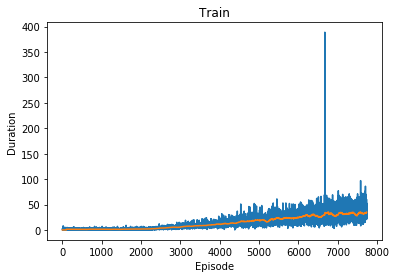

In [33]:
# количество эпизодов, которые играем
NUM_EPISODES = 100000

# количество кадров, между которыми обучаем модель
OPTIMIZE_MODEL_STEP = 5
# количество кадров, между которыми обновляем target-модель
TARGET_UPDATE=10000

# несколько шагов для разогрева модели()
STEPS_BEFORE_TRAIN = 50000

policy_net.train()
target_net.eval()
i=0
state_holder = StateHolder()
test_rewards = []


# Задание 3. Заполнить пропуски в нижеприведенном коде.

for e in tqdm.tqdm_notebook(range(NUM_EPISODES)):
    env.reset()
    state_holder.reset()
    state_holder.push(get_screen())
    lives = 5
    ep_rewards = []
    state=state_holder.get()
    for t in count():
        
        action = select_action(state)
        _, reward, done, info = env.step(action.item())
        ep_rewards.append(reward)
        reward = torch.tensor([reward], device=device)
        
        if not done:
            if (info['ale.lives']!=lives):
                lives=info['ale.lives']
                state_holder.reset()
                state_holder.push(get_screen())
                memory.push(state, action,None,reward)
                state = state_holder.get()
            else:
                state_holder.push(get_screen())
                next_state = state_holder.get()
                memory.push(state, action, next_state, reward)
                state = next_state
        else:
            next_state = None
            memory.push(state, action, next_state, reward)
            
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            if (i==0):
                print("start train")
                i=1
            optimize_model()
        
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
        
        # Код завершающий эпизод игры/обучения
        
        if done:
            train_rewards.append(np.sum(ep_rewards))
            # Суммарный reward(не дисконтированный) за последний эпизод
            print("episode:", e, "  score:", train_rewards[-1], "  mean:",np.mean(train_rewards[-100:]))
            #print("Episode score : {}".format(train_rewards[-1]))
            # Средний reward по последним 100 эпизодам
            #print("Mean score : {}".format(np.mean(train_rewards[-100:])))
            plot_rewards()
            break 



In [34]:
print("Mean score : {}".format(np.mean(train_rewards[-100:])))

Mean score : 35.31


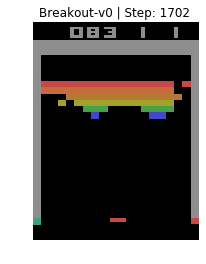

Total game reward : 83.0


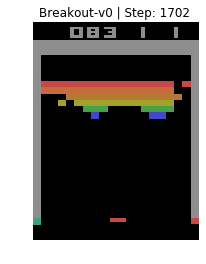

In [39]:
# Тут код для тестирования.
# Задание 4. Просто выполнить данную ячейку и проверить вашего агента, насколько он хорош !?

TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def select_action(state,eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

policy_net.eval()
env.reset()
state_holder.reset()
    
state_holder.push(get_screen())

total_reward = 0

for i in count():
    # Выбрать и выполнить нове действие
    action = select_action(state_holder.get(), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen())
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))